In [1]:
# fer un model de RF amb Cross validation i SMOTE per fine tuning o Optuna

In [2]:
import sys
# Aquesta comanda li pregunta al Python que està executant el kernel:
# "Mostra'm la informació del paquet ipympl"
# !{sys.executable} -m pip show ipympl

In [3]:
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns

In [4]:
df = pd.read_csv(r"C:\Users\ferra\OneDrive\Documentos\Ubiqum\The Credit One Project\credit_one.csv")
df = df.drop('ID', axis=1) # Treiem columna ID
df.rename(columns={'PAY_0': 'PAY_1'}, inplace=True) # Substituïr PAY_0 per PAY_1 per mantenir una cronología
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
# Suposem que les columnes són PAY_1, PAY_2, ..., PAY_6
for i in range(1, 7):
    col = f'PAY_{i}'
    print("Ara estem a l'iteració número : ", i, ". A la columna : ", col, ".\n")
    df[f'{col}_ontime'] = (df[col] == -1).astype(int)
    df[f'{col}_sensemov'] = (df[col] == -2).astype(int)
    df[f'{col}_revolving'] = (df[col] == 0).astype(int)
    df[f'{col}_mesos_retard'] = (df[col] > 0).astype(int)
    print("Acabem el loop número ", i)

Ara estem a l'iteració número :  1 . A la columna :  PAY_1 .

Acabem el loop número  1
Ara estem a l'iteració número :  2 . A la columna :  PAY_2 .

Acabem el loop número  2
Ara estem a l'iteració número :  3 . A la columna :  PAY_3 .

Acabem el loop número  3
Ara estem a l'iteració número :  4 . A la columna :  PAY_4 .

Acabem el loop número  4
Ara estem a l'iteració número :  5 . A la columna :  PAY_5 .

Acabem el loop número  5
Ara estem a l'iteració número :  6 . A la columna :  PAY_6 .

Acabem el loop número  6


In [6]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_4_revolving,PAY_4_mesos_retard,PAY_5_ontime,PAY_5_sensemov,PAY_5_revolving,PAY_5_mesos_retard,PAY_6_ontime,PAY_6_sensemov,PAY_6_revolving,PAY_6_mesos_retard
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,1,0,0,0,1,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,90000,2,2,2,34,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,50000,2,2,1,37,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,1,0,0,0,1,0,0,0,1,0


In [7]:
df = df.drop(columns=['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])

In [8]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'PAY_1_ontime', 'PAY_1_sensemov',
       'PAY_1_revolving', 'PAY_1_mesos_retard', 'PAY_2_ontime',
       'PAY_2_sensemov', 'PAY_2_revolving', 'PAY_2_mesos_retard',
       'PAY_3_ontime', 'PAY_3_sensemov', 'PAY_3_revolving',
       'PAY_3_mesos_retard', 'PAY_4_ontime', 'PAY_4_sensemov',
       'PAY_4_revolving', 'PAY_4_mesos_retard', 'PAY_5_ontime',
       'PAY_5_sensemov', 'PAY_5_revolving', 'PAY_5_mesos_retard',
       'PAY_6_ontime', 'PAY_6_sensemov', 'PAY_6_revolving',
       'PAY_6_mesos_retard'],
      dtype='object')

In [9]:
cols1 = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
df['BILL_AMT_AGRUPAT'] = df[cols1].mean(axis=1)
df.drop(cols1, axis=1, inplace=True)
cols2 = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df['PAY_AMT_AGRUPAT'] = df[cols2].mean(axis=1)
df.drop(cols2, axis=1, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default payment next month,PAY_1_ontime,PAY_1_sensemov,PAY_1_revolving,PAY_1_mesos_retard,...,PAY_5_ontime,PAY_5_sensemov,PAY_5_revolving,PAY_5_mesos_retard,PAY_6_ontime,PAY_6_sensemov,PAY_6_revolving,PAY_6_mesos_retard,BILL_AMT_AGRUPAT,PAY_AMT_AGRUPAT
0,20000,2,2,1,24,1,0,0,0,1,...,0,1,0,0,0,1,0,0,1284.000000,114.833333
1,120000,2,2,2,26,1,1,0,0,0,...,0,0,1,0,0,0,0,1,2846.166667,833.333333
2,90000,2,2,2,34,0,0,0,1,0,...,0,0,1,0,0,0,1,0,16942.166667,1836.333333
3,50000,2,2,1,37,0,0,0,1,0,...,0,0,1,0,0,0,1,0,38555.666667,1398.000000
4,50000,1,2,1,57,0,1,0,0,0,...,0,0,1,0,0,0,1,0,18223.166667,9841.500000


In [10]:
etiquetes = {1: 'male', 2: 'female'}
df['SEX'] = df['SEX'].map(etiquetes)
encoder = OneHotEncoder(sparse_output=False, drop='first')
df_codificat = pd.DataFrame(encoder.fit_transform(df[['SEX']]), columns=encoder.get_feature_names_out(['SEX']), index=df.index)
df_final = df.drop(columns=['SEX']).join(df_codificat)
df_final.head()
df = df_final
df.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,default payment next month,PAY_1_ontime,PAY_1_sensemov,PAY_1_revolving,PAY_1_mesos_retard,PAY_2_ontime,...,PAY_5_sensemov,PAY_5_revolving,PAY_5_mesos_retard,PAY_6_ontime,PAY_6_sensemov,PAY_6_revolving,PAY_6_mesos_retard,BILL_AMT_AGRUPAT,PAY_AMT_AGRUPAT,SEX_male
0,20000,2,1,24,1,0,0,0,1,0,...,1,0,0,0,1,0,0,1284.000000,114.833333,0.0
1,120000,2,2,26,1,1,0,0,0,0,...,0,1,0,0,0,0,1,2846.166667,833.333333,0.0
2,90000,2,2,34,0,0,0,1,0,0,...,0,1,0,0,0,1,0,16942.166667,1836.333333,0.0
3,50000,2,1,37,0,0,0,1,0,0,...,0,1,0,0,0,1,0,38555.666667,1398.000000,0.0
4,50000,2,1,57,0,1,0,0,0,0,...,0,1,0,0,0,1,0,18223.166667,9841.500000,1.0


In [11]:
map = {1: 'postgrau',2: 'universitari',3: 'secundaria',4: 'altres'}
df['EDUCATION'] = df['EDUCATION'].map(map)
df['EDUCATION'] = df['EDUCATION'].fillna('altres') # Gestió de valors no mapejats (ex: 0, 5, 6): els assignem a 'altres'
columna_a_codificar = df[['EDUCATION']]
df_restant = df.drop(columns=['EDUCATION'])
encoder = OneHotEncoder(sparse_output=False, drop='first')
dades_codificades = encoder.fit_transform(columna_a_codificar)
df_codificat = pd.DataFrame(dades_codificades, columns=encoder.get_feature_names_out(['EDUCATION']))
# Unim les dades restants amb les noves columnes codificades
df_final = pd.concat([df_restant, df_codificat], axis=1)
# Creem un DataFrame amb totes les columnes menys 'EDUCATION'
df_restant = df.drop(columns=['EDUCATION'])
# Unim els dos DataFrames, un al costat de l'altre
df_final = pd.concat([df_restant, df_codificat], axis=1)
# 3. MOSTRAR RESULTAT
print("DataFrame Final amb la columna 'EDUCATION' codificada:")
df = df_final
df.head()

DataFrame Final amb la columna 'EDUCATION' codificada:


,LIMIT_BAL,MARRIAGE,AGE,default payment next month,PAY_1_ontime,PAY_1_sensemov,PAY_1_revolving,PAY_1_mesos_retard,PAY_2_ontime,PAY_2_sensemov,...,PAY_6_ontime,PAY_6_sensemov,PAY_6_revolving,PAY_6_mesos_retard,BILL_AMT_AGRUPAT,PAY_AMT_AGRUPAT,SEX_male,EDUCATION_postgrau,EDUCATION_secundaria,EDUCATION_universitari
0,20000,1,24,1,0,0,0,1,0,0,...,0,1,0,0,1284.000000,114.833333,0.0,0.0,0.0,1.0
1,120000,2,26,1,1,0,0,0,0,0,...,0,0,0,1,2846.166667,833.333333,0.0,0.0,0.0,1.0
2,90000,2,34,0,0,0,1,0,0,0,...,0,0,1,0,16942.166667,1836.333333,0.0,0.0,0.0,1.0
3,50000,1,37,0,0,0,1,0,0,0,...,0,0,1,0,38555.666667,1398.000000,0.0,0.0,0.0,1.0
4,50000,1,57,0,1,0,0,0,0,0,...,0,0,1,0,18223.166667,9841.500000,1.0,0.0,0.0,1.0


In [12]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0], dtype=int64)

In [13]:
labels = {1: 'casat',2: 'solter',3: 'altres',0: 'altres'}
df['MARRIAGE'] = df['MARRIAGE'].map(labels)
encoder = OneHotEncoder(sparse_output=False, drop='first')
df_codificat = pd.DataFrame(encoder.fit_transform(df[['MARRIAGE']]), columns=encoder.get_feature_names_out(['MARRIAGE']), index=df.index)
df_final = df.drop(columns=['MARRIAGE']).join(df_codificat)
df_final
df = df_final
df.head()

,LIMIT_BAL,AGE,default payment next month,PAY_1_ontime,PAY_1_sensemov,PAY_1_revolving,PAY_1_mesos_retard,PAY_2_ontime,PAY_2_sensemov,PAY_2_revolving,...,PAY_6_revolving,PAY_6_mesos_retard,BILL_AMT_AGRUPAT,PAY_AMT_AGRUPAT,SEX_male,EDUCATION_postgrau,EDUCATION_secundaria,EDUCATION_universitari,MARRIAGE_casat,MARRIAGE_solter
0,20000,24,1,0,0,0,1,0,0,0,...,0,0,1284.000000,114.833333,0.0,0.0,0.0,1.0,1.0,0.0
1,120000,26,1,1,0,0,0,0,0,0,...,0,1,2846.166667,833.333333,0.0,0.0,0.0,1.0,0.0,1.0
2,90000,34,0,0,0,1,0,0,0,1,...,1,0,16942.166667,1836.333333,0.0,0.0,0.0,1.0,0.0,1.0
3,50000,37,0,0,0,1,0,0,0,1,...,1,0,38555.666667,1398.000000,0.0,0.0,0.0,1.0,1.0,0.0
4,50000,57,0,1,0,0,0,0,0,1,...,1,0,18223.166667,9841.500000,1.0,0.0,0.0,1.0,1.0,0.0


In [14]:
df.rename(columns={'default payment next month': 'default'}, inplace=True)
df.head()

,LIMIT_BAL,AGE,default,PAY_1_ontime,PAY_1_sensemov,PAY_1_revolving,PAY_1_mesos_retard,PAY_2_ontime,PAY_2_sensemov,PAY_2_revolving,...,PAY_6_revolving,PAY_6_mesos_retard,BILL_AMT_AGRUPAT,PAY_AMT_AGRUPAT,SEX_male,EDUCATION_postgrau,EDUCATION_secundaria,EDUCATION_universitari,MARRIAGE_casat,MARRIAGE_solter
0,20000,24,1,0,0,0,1,0,0,0,...,0,0,1284.000000,114.833333,0.0,0.0,0.0,1.0,1.0,0.0
1,120000,26,1,1,0,0,0,0,0,0,...,0,1,2846.166667,833.333333,0.0,0.0,0.0,1.0,0.0,1.0
2,90000,34,0,0,0,1,0,0,0,1,...,1,0,16942.166667,1836.333333,0.0,0.0,0.0,1.0,0.0,1.0
3,50000,37,0,0,0,1,0,0,0,1,...,1,0,38555.666667,1398.000000,0.0,0.0,0.0,1.0,1.0,0.0
4,50000,57,0,1,0,0,0,0,0,1,...,1,0,18223.166667,9841.500000,1.0,0.0,0.0,1.0,1.0,0.0


In [15]:
# df.to_csv('credit_one_featured.csv', index=False)

In [16]:
y = df['default']
X = df.drop(columns=['default'])

In [17]:
X.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_1_ontime', 'PAY_1_sensemov', 'PAY_1_revolving',
       'PAY_1_mesos_retard', 'PAY_2_ontime', 'PAY_2_sensemov',
       'PAY_2_revolving', 'PAY_2_mesos_retard', 'PAY_3_ontime',
       'PAY_3_sensemov', 'PAY_3_revolving', 'PAY_3_mesos_retard',
       'PAY_4_ontime', 'PAY_4_sensemov', 'PAY_4_revolving',
       'PAY_4_mesos_retard', 'PAY_5_ontime', 'PAY_5_sensemov',
       'PAY_5_revolving', 'PAY_5_mesos_retard', 'PAY_6_ontime',
       'PAY_6_sensemov', 'PAY_6_revolving', 'PAY_6_mesos_retard',
       'BILL_AMT_AGRUPAT', 'PAY_AMT_AGRUPAT', 'SEX_male', 'EDUCATION_postgrau',
       'EDUCATION_secundaria', 'EDUCATION_universitari', 'MARRIAGE_casat',
       'MARRIAGE_solter'],
      dtype='object')

In [18]:
X.shape

(30000, 34)

In [19]:
# Un cop tinc enllestic el Featuring m'el guardo a una base de dades per no haver d'estar fent sempre els passo previs

EXPORT A SQL

Codi per a SQLite original
1. Crear el 'motor' de connexió a la base de dades
Aquí defineixes el nom del FITXER. Si no existeix, es crearà.
engine = create_engine('sqlite:///credit_one_dades.sqlite')
2. Exportar el DataFrame 'df' a una TAULA SQL
Aquí defineixes el nom de la TAULA i altres paràmetres.
df.to_sql(
    'dades_netes',        # Nom que tindrà la taula dins de la base de dades
    con=engine,           # La connexió que acabem de crear
    if_exists='replace',  # Si la taula ja existeix, la reemplaça
    index=False           # No inclou l'índex de Pandas com a columna
)
print("DataFrame exportat amb èxit a 'credit_one_dades.sqlite' a la taula 'dades_netes'.")

In [22]:
# 1. Defineix els noms del fitxer i de la taula
nom_fitxer_db = 'credit_one_dades.sqlite'
nom_taula = 'dades_netes'
# 2. Crea la connexió directament amb sqlite3
conn = sqlite3.connect(nom_fitxer_db)
# 3. Exporta el DataFrame a la taula SQL
df.to_sql(
    nom_taula,
    con=conn,
    if_exists='replace',
    index=False
)
# 4. Confirma i guarda els canvis al fitxer (AQUEST ÉS EL PAS CLAU)
conn.commit()
# 5. Tanca la connexió (bona pràctica)
conn.close()
print(f"DataFrame exportat amb èxit a '{nom_fitxer_db}' a la taula '{nom_taula}'.")

DataFrame exportat amb èxit a 'credit_one_dades.sqlite' a la taula 'dades_netes'.


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Anem amb la part del Pipeline
# Crear-lo ens assegura treballar de forma endreçada i evitar DataLeak (desdes contaminades)

1) Definir integrants Pipeline
2) Definir Hiperparàmetres del model
3) Definir estratègia de validació
4) Definir objecte GridSearchCV
5) Entrenar-lo

In [26]:
# pipeline = Pipeline([('smote', SMOTE(random_state=99)), ('rf', RandomForestClassifier(random_state=99))])
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)
])
pipeline

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [27]:
# Aquesta és la graella de paràmetres que GridSearchCV provarà.
params = {
    'rf__n_estimators': [180, 185],        # Nombre d'arbres al bosc
    'rf__max_depth': [4, 6],               # Profunditat màxima de cada arbre
    'rf__min_samples_leaf': [170, 175]     # Mínim de mostres per fulla
    'rf__class_weight': [None, 'balanced']
}

In [28]:
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# escullo aquesta estratègia donat que hi ha poques dades d'impagaments # classes desbalancejades
# shuffle=True per barrejar els folds i random_state per escollir cada vegada de la mateixa forma # 42 es anecdòtic podria esser 99, l'important es que sempre sigui el mateix número

In [29]:
# Creem l'objecte GridSearchCV ajuntant totes les peces:
# 1. estimator=pipeline -> La nostra "cadena de muntatge"
# 2. param_grid=params -> El nostre "menú" d'opcions
# 3. cv=cv_strategy -> El nostre "jutge" (Validació Creuada Estratificada)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv_strategy,
    scoring='recall',  # f1 Mètrica robusta per a desequilibri de classes
    n_jobs=-1,         # Utilitza tots els nuclis de la CPU per anar més ràpid
    verbose=2,         # Mostra informació del progrés
)
print("GridSearchCV configurat i a punt per entrenar.")

GridSearchCV configurat i a punt per entrenar.


In [30]:
grid_search.fit(X, y)
print("Entrenament completat!")
# Aquesta línia mostra la millor combinació d'hiperparàmetres
print(f"Millors paràmetres trobats: {grid_search.best_params_}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Entrenament completat!
Millors paràmetres trobats: {'rf__max_depth': 4, 'rf__min_samples_leaf': 170, 'rf__n_estimators': 180}


In [31]:
# Aquesta línia mostra la millor puntuació F1 obtinguda
print(f"Millor puntuació F1 (macro) amb CV: {grid_search.best_score_:.4f}")

Millor puntuació F1 (macro) amb CV: 0.5285


In [32]:
preds = grid_search.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4687
           1       0.52      0.53      0.52      1313

    accuracy                           0.79      6000
   macro avg       0.69      0.70      0.69      6000
weighted avg       0.79      0.79      0.79      6000



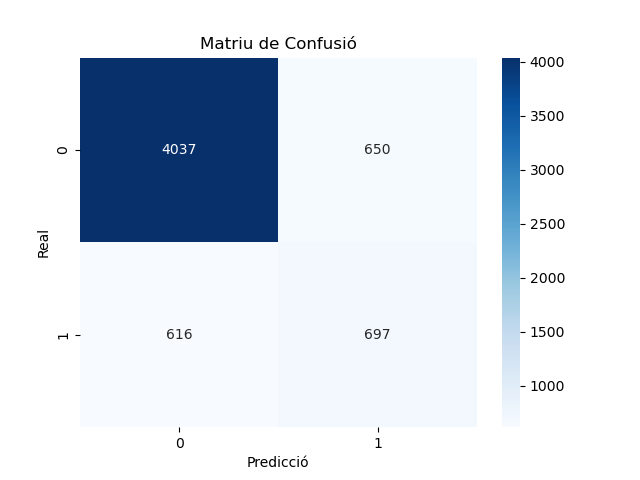

In [33]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicció")
plt.ylabel("Real")
plt.title("Matriu de Confusió")
plt.show()

# Per millorar F1 de 1, cal retocar els hiperparàmetres, per ex:
params = {
    'rf__n_estimators': [150, 250],         # Més arbres per a un millor consens
    'rf__max_depth': [5, 10],                # Arbres menys profunds, més simples
    'rf__min_samples_leaf': [4, 8],          # Exigir més mostres per fulla, simplifica
    'rf__max_features': ['sqrt', 'log2']     # Augmenta la diversitat
}

Grafica per a Precision - Recall

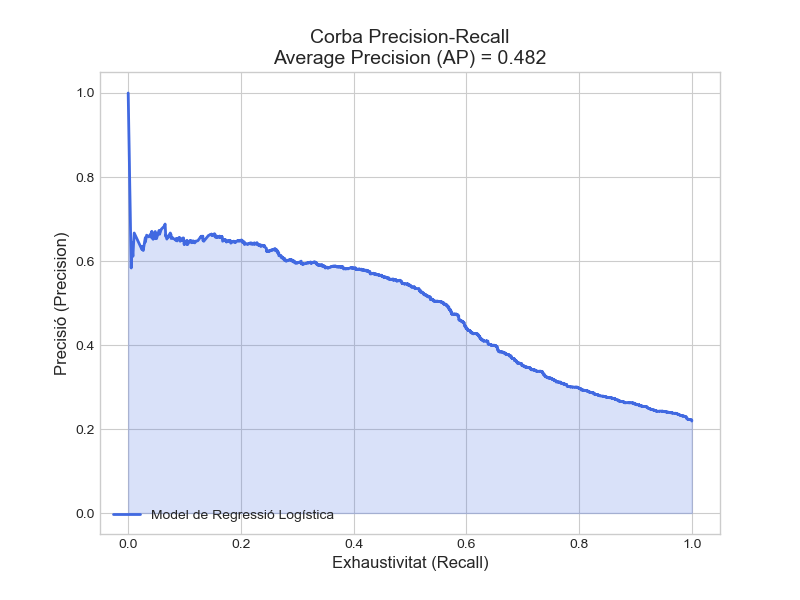

In [36]:
# --- 7. Obtenció de les Probabilitats i Càlcul de la Corba ---
y_scores = grid_search.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap_score = average_precision_score(y_test, y_scores)
# --- 8. Dibuix de la Corba ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='royalblue', lw=2, label=f'Model de Regressió Logística')
plt.fill_between(recall, precision, alpha=0.2, color='royalblue')
plt.xlabel('Exhaustivitat (Recall)', fontsize=12)
plt.ylabel('Precisió (Precision)', fontsize=12)
plt.title(f'Corba Precision-Recall\nAverage Precision (AP) = {ap_score:.3f}', fontsize=14)
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

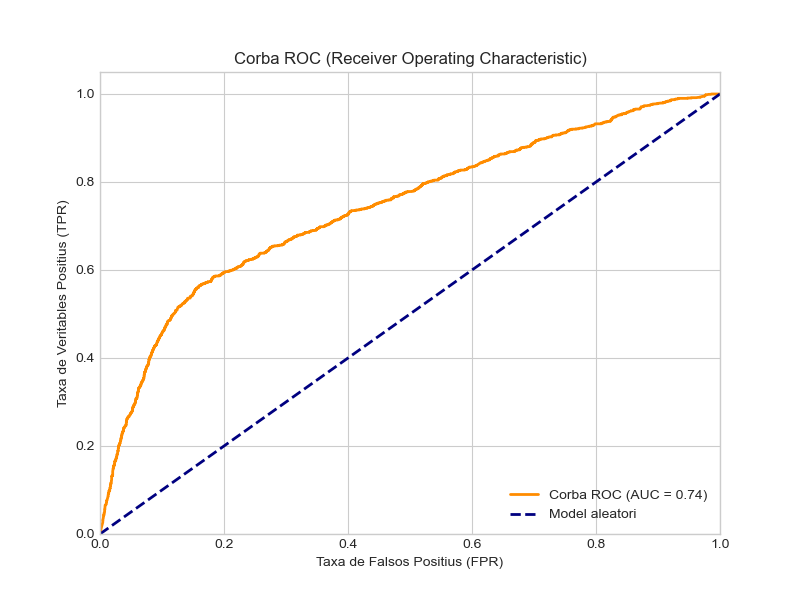

In [37]:
# --- 7. Gràfic de la Corba ROC ---
# Calculem la taxa de veritables positius (tpr) i la taxa de falsos positius (fpr)
fpr, tpr, _ = roc_curve(y_test, y_scores)
# Calculem l'àrea sota la corba ROC (AUC)
roc_auc = auc(fpr, tpr)
# Dibuixem la corba ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Corba ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Model aleatori') # Línia de referència
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positius (FPR)')
plt.ylabel('Taxa de Veritables Positius (TPR)')
plt.title('Corba ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Threshold Tuning

In [39]:
millor_model_optimitzat = grid_search.best_estimator_
probabilitats = millor_model_optimitzat.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probabilitats)
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
millor_llindar = thresholds[np.argmax(f1_scores)]
print("-" * 50)
print(f"Llindar per defecte: 0.5")
print(f"Millor llindar trobat per maximitzar F1-score: {millor_llindar:.4f}")
print("-" * 50)
prediccions_finals_ajustades = (probabilitats >= millor_llindar).astype(int)
print("Nou Classification Report amb el llindar ajustat:")
print(classification_report(y_test, prediccions_finals_ajustades))

--------------------------------------------------
Llindar per defecte: 0.5
Millor llindar trobat per maximitzar F1-score: 0.4677
--------------------------------------------------
Nou Classification Report amb el llindar ajustat:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4687
           1       0.50      0.56      0.53      1313

    accuracy                           0.78      6000
   macro avg       0.69      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000



# Recall aconseguit 0.56